In [57]:
import numpy as np
import glob
from PTMCMCSampler import PTMCMCSampler

import scipy
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
from matplotlib import cm
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import timeit

In [58]:

def ClassMatrix(x, means):
    temp = np.zeros( shape=(x.shape[0], means.shape[0]) )
    #q = 9.21034 / 100
    for i in range( x.shape[0]):
        temp2=np.zeros( means.shape[0] )
        for j in range( means.shape[0] ):
            temp2[j] =np.dot( x[i] - means[j], x[i] - means[j] )
        index_min = np.argmin(temp2 )
        temp[i][index_min]=1
    return temp

#estimation of weights
def weights(x, means, size):
    #take a sample of size=size and calculate the weights
    indexes = np.random.choice( np.arange( 0, len(x) ), size=size, replace=False )
    temp=ClassMatrix(x[indexes], means)
    return np.mean(temp, 0)


def AFER( fw, tw):
    '''Average frecuency error rate 
    fw: frequency weight
    tw: true weight 
    Calculate \sum| fw-tw | '''
    return np.sum( np.abs(  fw-tw ) )
    

def fpoints(f, args, theta,  pars , lb, upb, m=100):
    '''f is the objective function to be plotted
       args are the arguments of f as a list
       theta is the vector of true parameters
       pars are the parameters to be plotted (passed as an array)
       lb: array of lower bounds
       upb: array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])

    for i in range( m ):
        for j in range( m ):
            temp=np.array( [xx[i][j], yy[i][j]] )
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()    

# log target f(x) case a

# log target f(x)
def logf(x):
    if(x[0]>0 and x[0]>0 and x[0]<10 and x[1]<10   ):
      w = (1.0 / num_mixtures) * np.ones( num_mixtures )
      v = 1.0 / (10.0) * np.ones( num_mixtures )
      return np.log( np.sum( (w / v ** 2) * np.exp( -1.0 / (2.0 * v ** 2) * np.sum( np.square( x - mu ), 1 ) ) ) )
    else:
      return -np.inf 


def Analysis(x):
    mean=np.mean(x,0)
    var=np.var(x,0)

    ess1 = tfp.mcmc.effective_sample_size(  x[:,0] , filter_beyond_positive_pairs=True)
    ess2 = tfp.mcmc.effective_sample_size(  x[:,1] , filter_beyond_positive_pairs=True)

    ess=min(ess1, ess2)    

    summary= {
        "Mean": mean,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        }
    return summary



In [59]:

class PT_target(object):
    
    # log target f(x)
    def logf(self,x):
        if(x[0]>0 and x[0]>0 and x[0]<10 and x[1]<10   ):
          w = (1.0 / num_mixtures) * np.ones( num_mixtures )
          v = 1.0 / (10.0) * np.ones( num_mixtures )
          return np.log( np.sum( (w / v ** 2) * np.exp( -1.0 / (2.0 * v ** 2) * np.sum( np.square( x - mu ), 1 ) ) ) )
        else:
          return -np.inf 



    
    def log_prior(self, x):
        return 0
    

        
        
        

In [60]:


mu = np.array(
    [[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60],
     [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], [4.93, 1.5],
     [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]] )

num_mixtures = 20 #number of mixture components
dim = 2  # mixture of bivariate Gaussians



In [11]:
f=PT_target()
cov=np.diag([ 1,1])

In [70]:

M=50
T=50000
bi=int(T*0.15)

AFERhatPT=np.zeros(M)
ndisModesPT=np.zeros(M)
hatIATPT=np.zeros(M)

sample_PT1=np.zeros([ T-1000, M ])
sample_PT2=np.zeros([ T-1000, M ])
times=np.zeros(M)


for i in range(M):
    print('ITERATION: ', i)
    sampler = PTMCMCSampler.PTSampler(dim, f.logL , f.log_prior, np.copy(cov), outDir='PTcaseA/chains', resume=False)
    p0=scipy.stats.uniform.rvs(0,10,2)
 
    
   
    a=timeit.timeit()
    sampler.sample(p0, T, burn= bi  , thin=1, covUpdate=500,
               SCAMweight=30, AMweight=0, DEweight=50, HMCweight=0, HMCsteps=0)
   
    b=timeit.timeit()
    times[i]=b-a
    
    data = np.loadtxt('PTcaseA/chains/chain_1.txt') #if T is chaneged be sure to create new directory for chain
    PTchain = data[:,:-4]
    
    ssize=PTchain[ bi:,0:2].shape[0]
    print('Calculating weights for iteration: ', i)
    ws_t=weights( PTchain[ bi:,0:2], means= mu, size= ssize )
    
    ndisModesPT[i]=np.sum(ws_t>0)
    
    print('Calculating ess for iteration: ', i)
    ess1 = tfp.mcmc.effective_sample_size(  PTchain[bi:,0] , filter_beyond_positive_pairs=True)
    ess2 = tfp.mcmc.effective_sample_size(  PTchain[bi:,1] , filter_beyond_positive_pairs=True)

    ess=min(ess1, ess2)    
    
    hatIATPT[i]=ess
    
    sample_PT1[:,i]= PTchain[:,0]
    sample_PT2[:,i]= PTchain[:,1]
    
    AFERhatPT[i]=AFER(ws_t, 1/20)
   

ITERATION:  0


<ipython-input-7-ef22395194b8>:8: RuntimeWarning: divide by zero encountered in log
  return np.log( np.sum( (w / v ** 2) * np.exp( -1.0 / (2.0 * v ** 2) * np.sum( np.square( x - mu ), 1 ) ) ) )


Finished 14.00 percent in 1.981564 s Acceptance rate = 0.936714Adding DE jump with weight 50
Finished 98.00 percent in 12.439219 s Acceptance rate = 0.560327
Run Complete
Calculating weights for iteration:  0
Calculating ess for iteration:  0
ITERATION:  1
Finished 14.00 percent in 1.655632 s Acceptance rate = 0.523429Adding DE jump with weight 50
Finished 98.00 percent in 11.207391 s Acceptance rate = 0.399878
Run Complete
Calculating weights for iteration:  1
Calculating ess for iteration:  1
ITERATION:  2
Finished 14.00 percent in 1.652178 s Acceptance rate = 0.502714Adding DE jump with weight 50
Finished 98.00 percent in 10.483959 s Acceptance rate = 0.285498
Run Complete
Calculating weights for iteration:  2
Calculating ess for iteration:  2
ITERATION:  3
Finished 14.00 percent in 1.645011 s Acceptance rate = 0.935714Adding DE jump with weight 50
Finished 98.00 percent in 10.684255 s Acceptance rate = 0.773939
Run Complete
Calculating weights for iteration:  3
Calculating ess for 

In [72]:
PTchain.shape

(49000, 2)

In [79]:
print('Average AFER: ', np.mean(AFERhatPT))
print('Average # of Modes Discovered: ', np.mean(ndisModesPT))
print('Average neff: ', np.mean(hatIATPT))

Average AFER:  1.2641031325301204
Average # of Modes Discovered:  9.34
Average neff:  328.7153095715182


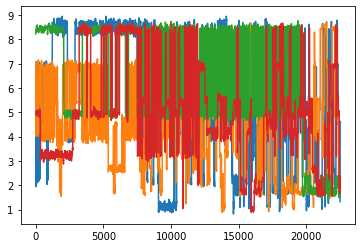

In [90]:
plt.plot(sample_PT1[bi:30000, 46:])


array([ 5.,  4., 20.,  1.,  2.,  1., 20.,  2.,  4., 20.,  4., 20.,  2.,
       20.,  2., 14.,  2., 20.,  2.,  2., 20.,  1.,  4., 20.,  2.,  4.,
       20., 20., 20.,  4.,  2., 20.,  2.,  3.,  2.,  2.,  2.,  4.,  2.,
        1.,  2., 20., 20., 20.,  2.,  1., 20., 20., 20., 20.])

In [ ]:


sample_PT1=np.zeros([ T-1000, M ])
sample_PT2=np.zeros([ T-1000, M ])
times=np.zeros(M)




In [92]:
print('Average x_1: ', np.mean(np.mean(np.mean(sample_PT1,0))) )
print('Average x_2: ', np.mean(np.mean(np.mean(sample_PT2,0))) )

Average x_1:  4.772368411432845
Average x_2:  4.772368411432845


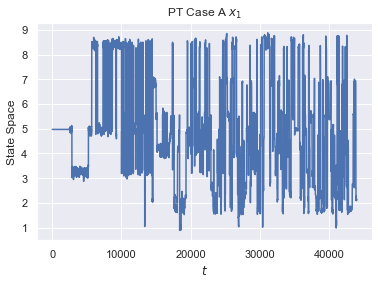

In [106]:
sns.set()
plt.plot(PTchain[5000:,0])
plt.xlabel( r'$t$' )
plt.ylabel( 'State Space' )
plt.title( r'PT Case A '+r'$x_1$'  )
plt.savefig('traceplot-PTAx1.png', dpi=500)    
plt.show()    

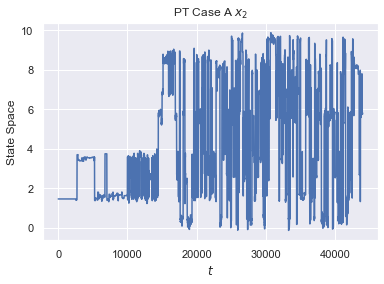

In [116]:
sns.set()
plt.plot(PTchain[5000:,1])
plt.xlabel( r'$t$' )
plt.ylabel( 'State Space' )
plt.title( r'PT Case A '+r'$x_2$' )
plt.savefig('traceplot-PTAx2.png', dpi=500)    
plt.show()    

In [113]:
xx,yy,Z= fpoints(f= logf ,args=(0,), theta=(), pars=(),
                  lb= np.array([0,0]), upb= np.array([10, 10]) , m=200 ) #takes time :)

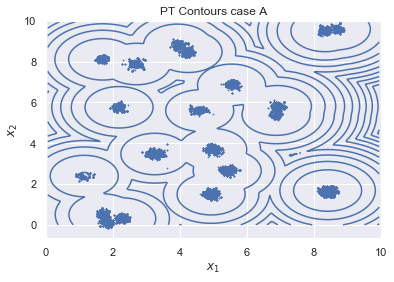

In [115]:
sns.set()
plt.contour( xx, yy, -Z, 10, colors='b' )
plt.scatter( PTchain[:, 0 ],PTchain[:, 1 ], s=0.5 )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.title( r'PT Contours case A' )
plt.savefig('PTContoursA.png', dpi=500)    
plt.show()    

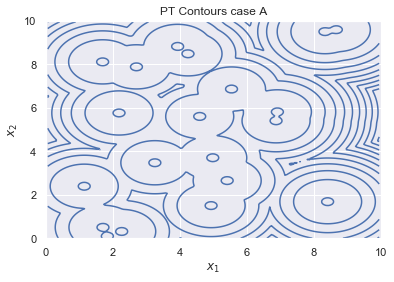

In [117]:
sns.set()
plt.contour( xx, yy, -Z, 10, colors='b' )
#plt.scatter( PTchain[:, 0 ],PTchain[:, 1 ], s=0.5 )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.title( r'PT Contours case A' )
plt.savefig('ex-ContoursCaseA.png', dpi=500)    
plt.show()   

In [120]:

np.mean(mu,0)

array([4.478, 4.905])